# Исследование тарифов федерального оператора сотовой связи.

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

## Описание тарифов
### Тариф «Смарт»

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 3 рубля
    сообщение: 3 рубля
    1 Гб интернет-трафика: 200 рублей

### Тариф «Ультра»

    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:

    минута разговора: 1 рубль
    сообщение: 1 рубль
    1 Гб интернет-трафика: 150 рублей
    
### Обратите внимание: 
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

### Описание данных
#### Таблица users (информация о пользователях):

   - user_id — уникальный идентификатор пользователя
   - first_name — имя пользователя
   - last_name — фамилия пользователя
   - age — возраст пользователя (годы)
   - reg_date — дата подключения тарифа (день, месяц, год)
   - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
   - city — город проживания пользователя
   - tariff — название тарифного плана

#### Таблица calls (информация о звонках):

   - id — уникальный номер звонка
   - call_date — дата звонка
   - duration — длительность звонка в минутах
   - user_id — идентификатор пользователя, сделавшего звонок

#### Таблица messages (информация о сообщениях):

   - id — уникальный номер сообщения
   - message_date — дата сообщения
   - user_id — идентификатор пользователя, отправившего сообщение

#### Таблица internet (информация об интернет-сессиях):

   - id — уникальный номер сессии
   - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
   - session_date — дата интернет-сессии
   - user_id — идентификатор пользователя

#### Таблица tariffs (информация о тарифах):

   - tariff_name — название тарифа
   - rub_monthly_fee — ежемесячная абонентская плата в рублях
   - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
   - messages_included — количество сообщений в месяц, включённых в абонентскую плату
   - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
   - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
   -  rub_per_message — стоимость отправки сообщения сверх тарифного пакета
   - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [109]:
#Проведем импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment=None
import math
import copy

In [110]:
#Загрузим данные для исследования
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Ознакомимся с данными,  проверим есть ли дубликаты и явные ошибки. Проведем предварительную обработку данных.

In [111]:
#посмотрим на данные о звонках
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [112]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [113]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [114]:
calls.duplicated().sum()

0

Данные без пропусков, нет дубликатов, это хорошо. Из описания нам известно, что оператор округляет продолжительность звонка до полной минуты, даже если пользователь говорил только 1 секунду. Необходимо округлить вверх время звонков. 

In [115]:
calls['duration'] = calls['duration'].apply(np.ceil)

Нужно изменить формат call_date на datetime и добавить в таблицу столбец с названием месяца.

In [116]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month


In [117]:
calls.head(10)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
9,1000_9,2018-08-15,0.0,1000,8


В таблице остались звонки продолжительностью 0.0 минут, можно предположить,что это случаи, когда номер был набран, но соединения не произошло. посмотрим как много таких строк в датафрейме.  

In [118]:
calls.query('duration == 0.0')

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
5,1000_5,2018-11-02,0.0,1000,11
6,1000_6,2018-10-18,0.0,1000,10
9,1000_9,2018-08-15,0.0,1000,8
...,...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499,12
202592,1499_205,2018-10-13,0.0,1499,10
202593,1499_206,2018-12-26,0.0,1499,12
202594,1499_207,2018-10-28,0.0,1499,10


In [119]:
print ("{0:.1f}%".format(39613/202607))

0.2%


Общее количество нетарифицируемых звонков продолжительностью 0.0 минут невелико - 0,2% от всего датафрейма. Данные строки можно удалить, так как они не влияют на расчет прибыльности тарифа



In [120]:
calls = calls[calls['duration'] != 0]
calls

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12
7,1000_7,2018-08-22,19.0,1000,8
8,1000_8,2018-09-15,19.0,1000,9
...,...,...,...,...,...
202602,1499_215,2018-12-26,1.0,1499,12
202603,1499_216,2018-10-18,19.0,1499,10
202604,1499_217,2018-11-10,11.0,1499,11
202605,1499_218,2018-10-06,5.0,1499,10


In [121]:
#посмотрим на таблицу 'internet'
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [122]:
internet.duplicated().sum()

0

In [123]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Данные полные, без пропусков и дубликатов

In [124]:
#округлим вверх количество мегабайт
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [125]:
internet['mb_used'].describe()

count    149396.000000
mean        370.622098
std         278.387019
min           0.000000
25%         139.000000
50%         349.000000
75%         560.000000
max        1725.000000
Name: mb_used, dtype: float64

Видим, что в таблице есть строки, где объем потраченного трафика за сессию составляет 0.0 мб. Посмотрим сколько их всего и относительно датафрейма

In [126]:
internet.query('mb_used == 0.0')

,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...,...
149380,149380,1499_141,0.0,2018-12-11,1499
149381,149381,1499_142,0.0,2018-11-01,1499
149383,149383,1499_144,0.0,2018-11-27,1499
149386,149386,1499_147,0.0,2018-10-21,1499


In [127]:
print ("{0:.1f}%".format(19598/149396))

0.1%


Количество таких строк невелико, это видимо случаи, когда соединение не получилось установить, удалим эти строки.

In [128]:
internet = internet[internet['mb_used'] != 0]


Также нужно изменить тип данных в столбце 'session_date' на datetime и добавить в таблицу столбец с названием месяца, а также привести данные об используемом объеме трафика в гигабайты и добавим столбец 'gb_used'


In [129]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['gb_used'] = (internet['mb_used'] / 1024)
#проверим результаты наших изменений
internet

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
0,0,1000_0,113.0,2018-11-25,1000,11,0.110352
1,1,1000_1,1053.0,2018-09-07,1000,9,1.028320
2,2,1000_2,1198.0,2018-06-25,1000,6,1.169922
3,3,1000_3,551.0,2018-08-22,1000,8,0.538086
4,4,1000_4,303.0,2018-09-24,1000,9,0.295898
...,...,...,...,...,...,...,...
149390,149390,1499_151,753.0,2018-10-11,1499,10,0.735352
149391,149391,1499_152,319.0,2018-10-03,1499,10,0.311523
149392,149392,1499_153,491.0,2018-12-14,1499,12,0.479492
149394,149394,1499_155,1247.0,2018-11-26,1499,11,1.217773


Посмотрим на данные о сообщениях

In [130]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [131]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [132]:
messages.duplicated().sum()

0

Данные полные, без дубликатов и пропусков. Нужно изменить тип данных в столбце 'message_date' на datetime и добавить в таблицу столбец с названием месяца

In [133]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [134]:
#выведем результат
messages

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


Посмотрим информацию о тарифах

In [135]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Интернет тарифицируется в гигабайтах, добавим в таблицу столбец 'gb_per_month_included'

In [136]:
tariffs['gb_per_month_included'] = (tariffs['mb_per_month_included'] / 1024)

In [137]:
#выведем результат, чтобы оценить изменения
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


Посмотрим на информацию о пользователях

In [138]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [139]:
users.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [140]:
users.duplicated().sum()

0

Есть очень много пропусков в столбце 'churn_date'. В описании данных отмечено, что "churn_date - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)". Можно заполнить эти пропуски, хотя их наличие не влияет на решение поставленных задач. у нас выборка данных за 2018 год. Поэтому можем проставить дату окончания действия тарифа как 01.01.2019
Дубликатов нет.
Нужно изменить тип данных в столбце 'reg_date' на datetime


In [141]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'].fillna('2019-01-01',inplace=True)

In [142]:
#проверим
users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,2019-01-01,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,2019-01-01,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,2019-01-01,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Итак, мы ознакомились с данными и провели их предварительную обработку. Теперь рассчитаем ряд показателей, необходимых для дальнейшего анализа.
Рассчитаем для каждого пользователя
 * количество сделанных звонков и израсходованных минут разговора по месяцам;
 * количество отправленных сообщений по месяцам;
 * объем израсходованного интернет-трафика по месяцам;
 * помесячную выручку с каждого пользователя (вычитаем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножаем на значение из тарифного плана; прибавляем абонентскую плату, соответствующую тарифному плану)
 
 

In [143]:
#сделаем сводные таблицы по нашим датафреймам, группируем их по user_id и месяцам, 
calls_grouped = calls.pivot_table(index=['user_id', 'month'], values='duration',
                                                   aggfunc=['sum', 'count'])
messages_grouped = messages.pivot_table(index=['user_id', 'month'], values='id',
                                                   aggfunc=['count'])
internet_grouped = internet.pivot_table(index=['user_id', 'month'], values='gb_used',
                                                   aggfunc=['sum'])


In [144]:
#объединим сгруппрированные данные в один датафрейм, назовем его merged_data_1. 
merged_data_1 = pd.concat([calls_grouped, messages_grouped, internet_grouped], axis=1)
merged_data_1 = merged_data_1.reset_index()
merged_data_1.head(10)

user_id month      sum    count              sum
                duration duration    id    gb_used
0    1000     5    159.0     17.0  22.0   2.203125
1    1000     6    172.0     28.0  60.0  22.711914
2    1000     7    340.0     41.0  75.0  13.687500
3    1000     8    408.0     42.0  81.0  13.740234
4    1000     9    466.0     46.0  57.0  14.239258
5    1000    10    350.0     44.0  73.0  14.372070
6    1000    11    338.0     37.0  58.0  14.421875
7    1000    12    333.0     38.0  70.0   9.596680
8    1001    11    430.0     45.0   NaN  18.019531
9    1001    12    414.0     47.0   NaN  13.723633

merged_data_1 отображает данные  по каждому пользователю помесячно по количеству звонков и их продолжительности, по количеству сообщений и по объему трафика.

In [145]:
# Объединим информацию о пользователях и merged_data_1
merged_data_2 = merged_data_1.merge(users,on='user_id', how='inner')
pd.options.mode.chained_assignment = None  # default='warn'


In [146]:
#изучим получившийся датафрейм
merged_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
user_id              3214 non-null int64
(user_id, )          3214 non-null int64
(month, )            3214 non-null int64
(sum, duration)      3168 non-null float64
(count, duration)    3168 non-null float64
(count, id)          2717 non-null float64
(sum, gb_used)       3201 non-null float64
age                  3214 non-null int64
churn_date           3214 non-null object
city                 3214 non-null object
first_name           3214 non-null object
last_name            3214 non-null object
reg_date             3214 non-null datetime64[ns]
tariff               3214 non-null object
dtypes: datetime64[ns](1), float64(4), int64(4), object(5)
memory usage: 376.6+ KB


In [147]:
#посмотрим на пропуски
gaps_in_the_data = pd.DataFrame({'percent_of_nulls':merged_data_2.isnull().sum()/len(merged_data_2)*100})
gaps_in_the_data

,percent_of_nulls
user_id,0.000000
"(user_id, )",0.000000
"(month, )",0.000000
"(sum, duration)",1.431238
"(count, duration)",1.431238
"(count, id)",15.463597
"(sum, gb_used)",0.404480
age,0.000000
churn_date,0.000000
city,0.000000


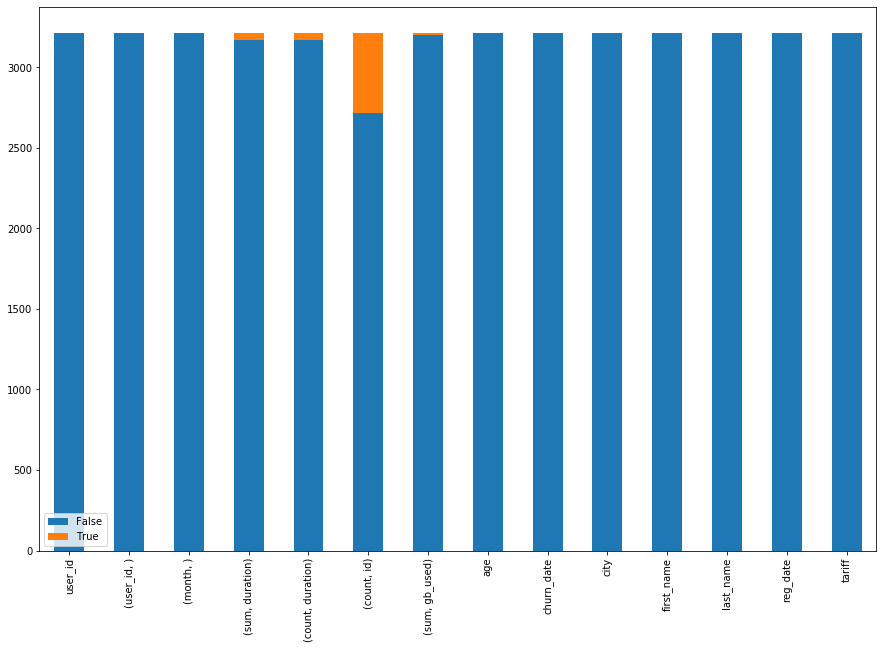

In [148]:
merged_data_2.isna().apply(pd.Series.value_counts).transpose().plot(kind = 'bar', stacked = True, figsize = (15,10))
plt.legend(loc='lower left')

Есть небольшое количество пропусков в столбцах Проставим по имеющимся пропускам нули, которые будут означать, что в конкретном месяце данный клиент не звонил/не отправлял СМС/не пользовался интернетом.
Также для удобства работы с таблицей переименуем столбцы

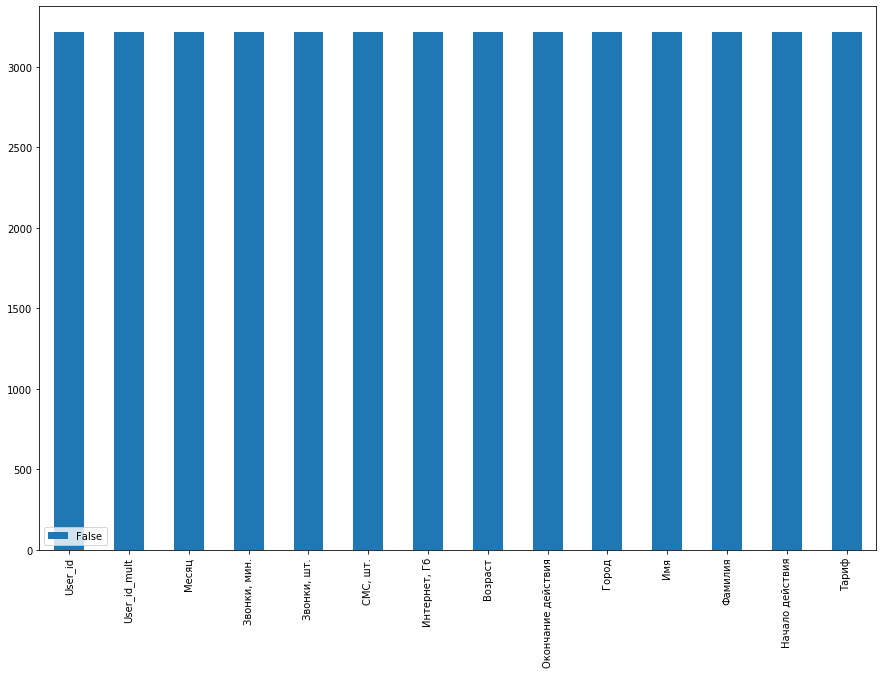

In [149]:
#переименуем столбцы
merged_data_2.columns = ['User_id','User_id_mult','Месяц', 'Звонки, мин.','Звонки, шт.', 
                            'СМС, шт.', 'Интернет, Гб', 'Возраст', 'Окончание действия',
                         'Город', 'Имя','Фамилия','Начало действия', 'Тариф']
merged_data_2 = merged_data_2.fillna(0)
merged_data_2.isna().apply(pd.Series.value_counts).transpose().plot(kind = 'bar', stacked = True, figsize = (15,10))
plt.legend(loc='lower left')


Отлично. 
Рассчитаем помесячную выручку с каждого пользователя.Добавим в датафрейм столбцы 'Абонентская плата,руб', и 'Выручка,руб'


In [150]:
monthly_rate = {'smart': 550, 'ultra': 1950}
merged_data_2['Абонентская плата,руб'] = merged_data_2['Тариф'].map(monthly_rate)


Создадим функцию для подсчета 

In [151]:
def over_limit(row):
    total_revenue = 0
    if row['Тариф'] == 'smart':
        if row['СМС, шт.'] > 50:
            messages_extra = (row['СМС, шт.'] - 50)*3
        else:
            messages_extra = 0
        if row['Звонки, шт.'] > 500:
            calls_extra = (row['Звонки, шт.'] - 500)*3
        else:
            calls_extra = 0
        if row['Интернет, Гб'] > 15:
            gb_extra = (row['Интернет, Гб'] - 15)*200
        else:
            gb_extra = 0
        total_revenue = messages_extra + calls_extra + gb_extra + 550
        
    if row['Тариф'] == 'ultra':
        if row['СМС, шт.'] > 1000:
            messages_extra = (row['СМС, шт.'] - 1000)*1
        else:
            messages_extra = 0
        if row['Звонки, шт.'] > 3900:
            calls_extra = (row['Звонки, шт.'] - 3000)*1
        else:
            calls_extra = 0
        if row['Интернет, Гб'] > 30:
            gb_extra = (row['Интернет, Гб'] - 30)*150
        else:
            gb_extra = 0
        total_revenue = messages_extra + calls_extra + gb_extra + 1950
    return total_revenue
merged_data_2['Выручка,руб'] = merged_data_2.apply(over_limit, axis=1)


In [152]:
merged_data_2

,User_id,User_id_mult,Месяц,"Звонки, мин.","Звонки, шт.","СМС, шт.","Интернет, Гб",Возраст,Окончание действия,Город,Имя,Фамилия,Начало действия,Тариф,"Абонентская плата,руб","Выручка,руб"
0,1000,1000,5,159.0,17.0,22.0,2.203125,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,1950.000000
1,1000,1000,6,172.0,28.0,60.0,22.711914,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,1950.000000
2,1000,1000,7,340.0,41.0,75.0,13.687500,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,1950.000000
3,1000,1000,8,408.0,42.0,81.0,13.740234,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,1950.000000
4,1000,1000,9,466.0,46.0,57.0,14.239258,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1950,1950.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,1498,10,247.0,30.0,42.0,20.121094,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,550,1574.218750
3210,1499,1499,9,70.0,8.0,11.0,1.804688,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,550,550.000000
3211,1499,1499,10,449.0,44.0,48.0,17.391602,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,550,1028.320312
3212,1499,1499,11,612.0,62.0,59.0,17.562500,35,2019-01-01,Пермь,Гектор,Корнилов,2018-09-27,smart,550,1089.500000


В результате обработки имеющихся исходных данных был получен новый объединенный датафрейм merged_data_2, и определено:   
  - количество сделанных звонков и израсходованных минут разговора по месяцам;
  - количество отправленных сообщений по месяцам;
  - объем израсходованного интернет-трафика по месяцам;
  - помесячная выручка с каждого пользователя

## Анализ Данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [153]:
#делаем срез данных по тарифу "Смарт"
smart = merged_data_2.query('Тариф == "smart"')

In [154]:
#Выведем средние количества и стандартное отклонение с помощью метода .describe()
smart[['Звонки, мин.', 'СМС, шт.', 'Интернет, Гб', 'Выручка,руб']].describe()

,"Звонки, мин.","СМС, шт.","Интернет, Гб","Выручка,руб"
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,15.848817,1108.532508
std,190.313730,28.227876,5.739821,707.933508
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,12.361328,550.000000
50%,422.000000,28.000000,16.143555,796.726562
75%,545.000000,51.000000,19.597656,1491.343750
max,1435.000000,143.000000,37.705078,5190.015625


In [155]:
#делаем срез данных по тарифу "Ультра"
ultra = merged_data_2.query('Тариф == "ultra"')

In [156]:
#Выведем средние количества и стандартное отклонение с помощью метода .describe()
ultra[['Звонки, мин.', 'СМС, шт.', 'Интернет, Гб', 'Выручка,руб']].describe()

,"Звонки, мин.","СМС, шт.","Интернет, Гб","Выручка,руб"
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.030177,2060.529971
std,317.606098,47.804457,9.859685,356.305046
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,6.000000,11.508789,1950.000000
50%,518.000000,38.000000,18.871094,1950.000000
75%,752.000000,79.000000,26.233398,1950.000000
max,1673.000000,224.000000,48.622070,4743.310547


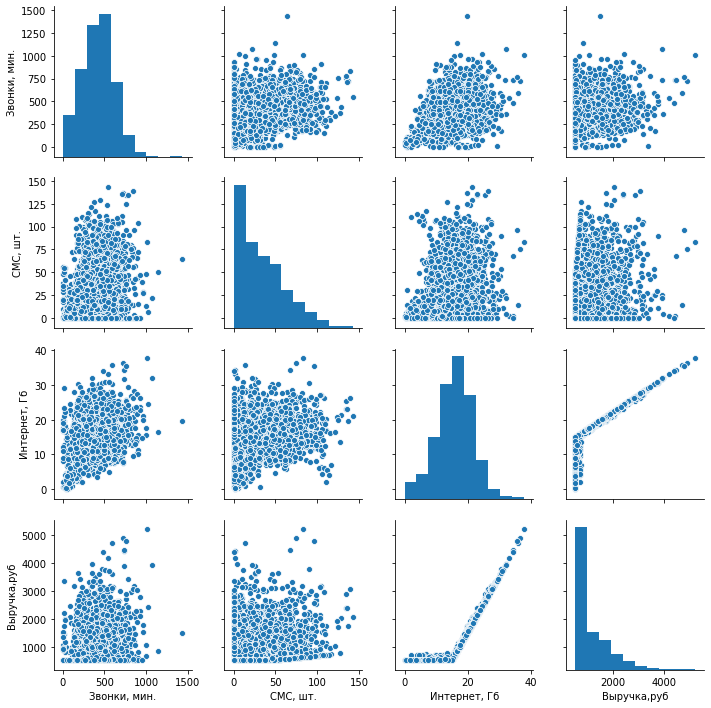

In [157]:

cols = ['Звонки, мин.', 'СМС, шт.', 'Интернет, Гб', 'Выручка,руб']
sns_plot_smart = sns.pairplot(smart[cols])
sns_plot_smart.savefig('pairplot.png')

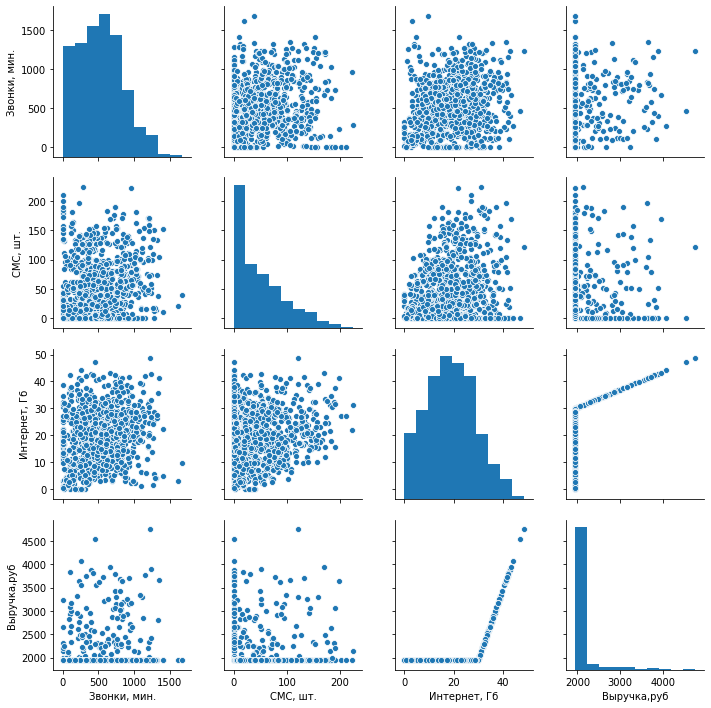

In [158]:
sns_plot_ultra = sns.pairplot(ultra[cols])
sns_plot_ultra.savefig('pairplot.png')

Распределения - тариф "Смарт"

    Кол-во минут - нормальное
    Кол-во СМС - распределение Пуассона
    Кол-во гигабайт - нормальное
    Выручка - нормальное

Распределения - тариф "Ультра"

    Кол-во минут - нормальное
    Кол-во СМС - распределение Пуассона
    Кол-во гигабайт - нормальное
    Выручка - нормальное

In [159]:
#посчитаем и выведем дисперсию
print('Дисперсия кол-во минут:', np.var(smart['Звонки, мин.']))
print('Дисперсия кол-во СМС:', np.var(smart['СМС, шт.']))
print('Дисперсия кол-во гигабайт:', np.var(smart['Интернет, Гб']))
print('Дисперсия выручка:', np.var(smart['Выручка,руб']))

Дисперсия кол-во минут: 36203.06665209469
Дисперсия кол-во СМС: 796.455482917076
Дисперсия кол-во гигабайт: 32.930767762221954
Дисперсия выручка: 500945.0116036671


построим матрицы размаха, чтобы определить выбросы

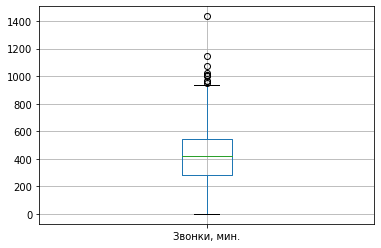

In [160]:
smart.boxplot(column='Звонки, мин.')

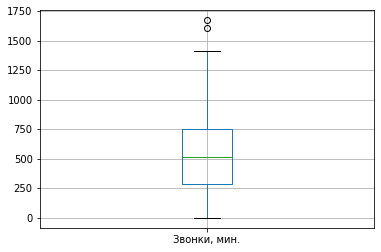

In [161]:
ultra.boxplot(column='Звонки, мин.')

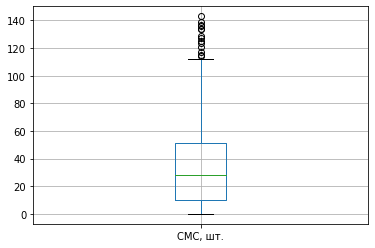

In [162]:
smart.boxplot(column='СМС, шт.')

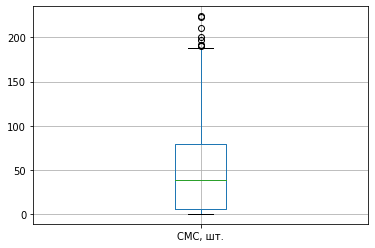

In [163]:
ultra.boxplot(column='СМС, шт.')

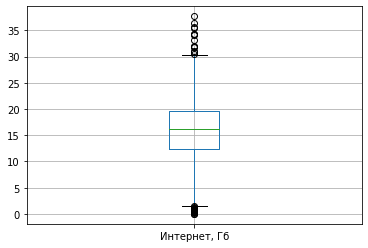

In [164]:
smart.boxplot(column='Интернет, Гб')

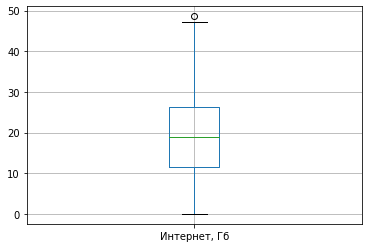

In [165]:
ultra.boxplot(column='Интернет, Гб')

### Выводы

На тарифе "Смарт" люди разговаривают в месяц в течение 250-550 минут. Медиана по продолжительности звонков выше 400 минут,а лимит ограничен 500 минутами. Можно сделать вывод, что многие пользователи превышают установленный лимит.
На тарифе "Ультра" люди разговаривают в месяц в течение 250-750 минут. Медиана по продолжительности звонков чуть выше 500 минут, а лимит на данном тарифе составляет 3000 минут, большинство пользователей тарифа не превышают этот лимит

Пользователи тарифа "Смарт" в среднем отправляют по 33 смс,что входит в лимит 50 сообщений по тарифу.
Пользователи тарифа "Ультра" в среднем отправляют по 50 смс,а лимит составляет 1000 сообщений. Можно сказать, что данный вид связи не пользуется большой популярностью.

Пользователи тарифа "Смарт" в основном используют от 12 до 20 Гб трафика. Причем медиана выше лимита в 15 Гб,установленного на данном тарифе. Соответственно большинство пользователей тарифа превышают установленный лимит.

Пользователи тарифа "Ультра" используют больше Гб - от 11 до 25 Гб, медиана меньше 20 гб, но так как лимит установленный на тарифе равен 30 Гб, большинству пользователей этого достаточно

В целом, пользлватели тарифа "Ультра" активнее пользуются связью, чем пользователи тарифа "Смарт"



## Проверим гипотезы

   1. средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
  

     Нулевой гипотезой будет гипотеза, что средние наших выборок равны. 
     Альтернативной гипотезой будет гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

Будем использовать метод scipy.stats.ttest_ind так как у нас 2 независимые выборки.

Можно придерживаться следующих условных границ зависимости объема выборки от уровня значимости. Если объем выборки небольшой до 100 единиц, то можно вполне отвергнуть нулевую гипотезу при уровне значимости 0,05 или даже 0,1. При объеме выборки, измеряемой сотнями – от 100 до 1000, следует понизить уровень значимости хотя бы до 0,01. 

Исходя из объема выборки, задаем критический уровень значимости как 0.01



In [166]:
from scipy import stats as st
alpha = 0.01
results = st.ttest_ind(smart['Выручка,руб'], ultra['Выручка,руб'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.0
Отвергаем нулевую гипотезу


In [172]:
ultra['Выручка,руб'].mean()

2060.5299710501267

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, исходя из проведенного анализа данных мы знаем, что средняя выручка по тарифу "Ультра" составляет 2060 рублей, а средняя выручка по тарифу "Смарт" составляет 1108 рублей.

 2. средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


Определим среднюю месячную выручку по Москве и по остальным регионам:

In [59]:
#создадим два среза, в одном будут все пользователи из Москвы, во второй - пользователи из других регионов
moscow = merged_data_2.query('Город == "Москва"')

In [60]:
other = merged_data_2.query('Город != "Москва"')

Нулевой гипотезой будет гипотеза, что средние наших выборок равны. 
Альтернативной гипотезой будет гипотеза "Средняя ввыручка пользователей из Москвы отличается от выручки пользователей из других регионов".

Будем использовать метод scipy.stats.ttest_ind так как у нас 2 независимые выборки.

Исходя из объема выборки, задаем критический уровень значимости как 0.01

In [61]:
alpha = 0.01
results = st.ttest_ind(moscow['Выручка,руб'], other['Выручка,руб'], equal_var = False)
print('P-value:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

P-value: 0.23468351124410233
Не получилось отвергнуть нулевую гипотезу


Нулевую гипотезу отвергнуть не получается.
Таким образом, верно утверждение, что средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов. 




## Общий вывод


Для проведения исследования прибыльности тарифов нам была предоставлена информация о пользователях, информация озвонках,информация о количестве смс и информация об интернет-сессиях. Была проведена предварительная обработка данных, а также рассчитано количество сделанных звонков и израсходованных минут разговора по месяцам; количество отправленных сообщений по месяцам; объем израсходованного интернет-трафика по месяцам; и помесячная выручка с каждого пользователя.
На основе предоставленных данных мы создали объединенный датасет, по которому в дальнейшем провели анализ, посчитали
средние значения израсходованных минут, гигабайт и сообщений, а также среднюю выручку в зависимости от тарифа. Далее мы сформулировали и проверили правильность наших гипотез.

Пользователи тарифа "Ультра" активнее пользуются связью, и приносят компании "Мегалайн" больше денег. 
Пользователи тарифа "Смарт" часто выходят за установленные лимиты и оплачивают услуги сверх тарифного пакета. 
Возможно компании "Мегалайн" стоит разработать еще один тариф,промежуточный межу существующими двумя, который бы в большей степени отвечал потребностям потребителей в рамках установленной абонентской платы.

